# Imports

In [71]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# Data

In [5]:
train = pd.read_csv("../data/processed/SMOTE_df.csv")
validation = pd.read_csv("../data/processed/validation.csv")
test = pd.read_csv("../data/processed/test.csv")

In [6]:
y_train = train['readmitted_rescaled']
X_train = train.drop('readmitted_rescaled', axis=1)

y_val = validation['readmitted_rescaled']
X_val = validation.drop('readmitted_rescaled', axis=1)

y_test = test['readmitted_rescaled']
X_test = test.drop('readmitted_rescaled', axis=1)

In [7]:
def rename_column_names(colname):
    colname = "_".join(colname.split('-'))
    colname = "_".join(colname.split(','))
    colname = "_".join(colname.split('<'))
    colname = "_".join(colname.split('/'))
    colname = "_".join(colname.split('.'))
    colname = "_".join(colname.split('['))
    colname = "_".join(colname.split(']'))
    colname = "".join(colname.split(')'))
    colname = "_".join(colname.split('('))
    return colname
  

In [8]:
new_train_colnames = list(map(lambda x: rename_column_names(x), X_train.columns.tolist()))
new_val_colnames = list(map(lambda x: rename_column_names(x), X_val.columns.tolist()))
new_test_colnames = list(map(lambda x: rename_column_names(x), X_test.columns.tolist()))

In [9]:
X_train.columns = new_train_colnames
X_val.columns = new_val_colnames
X_test.columns = new_test_colnames

In [10]:
dvalidation = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Tuning the model on the validation data

In [11]:
# Load Model
loaded_model = xgb.Booster()
loaded_model.load_model("../models/best_model_001.model")

In [12]:
# Predict Probability
y_val_pred_proba = loaded_model.predict(dvalidation)

In [14]:
# Predict true value at a 0.5 threshold
y_val_preds = [1 if pred >0.5 else 0 for pred in y_val_pred_proba]

In [15]:
# Print 
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     10309
           1       0.21      0.01      0.03       961

    accuracy                           0.91     11270
   macro avg       0.56      0.50      0.49     11270
weighted avg       0.86      0.91      0.87     11270



## Baseline: Majority class prediction

In [16]:
baseline = float(len(validation[validation['readmitted_rescaled'] == 1]))/len(validation)
print("Baseline accuracy (majority class classifier): {}".format(baseline))

Baseline accuracy (majority class classifier): 0.08527062999112689


## Confusion Matrix

In [17]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f} threshold'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No Readmission Detected  (True Negatives) : ', cm[0][0])
    print('\nLegitimate No Readmission \nIncorrectly Detected as Readmission (False Positives): ', cm[0][1])
    print('\nLegitimate Readmission Missed       (False Negatives): ', cm[1][0])
    print('\nLegitimate Readmission Detected     (True Positives) : ', cm[1][1])

Legitimate No Readmission Detected  (True Negatives) :  10261

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  48

Legitimate Readmission Missed       (False Negatives):  948

Legitimate Readmission Detected     (True Positives) :  13


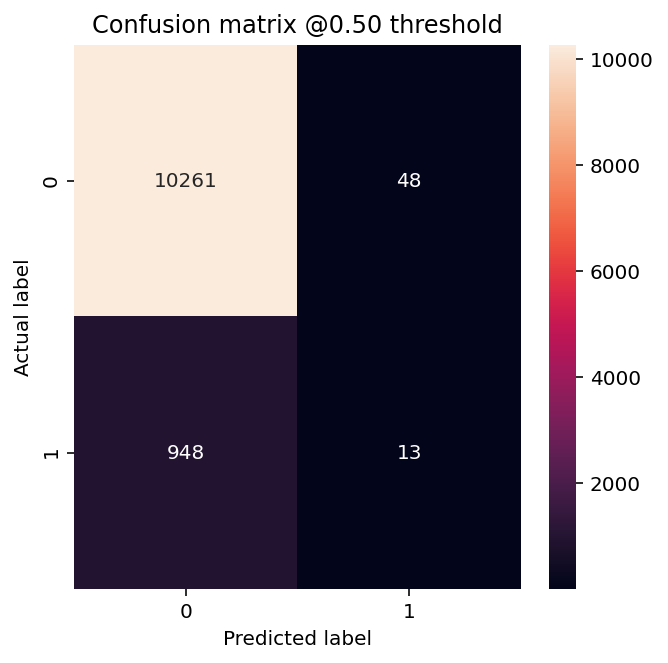

In [18]:
plot_cm(y_val, loaded_model.predict(dvalidation), p=0.5)

## Precision and Recall

In [19]:
precision = precision_score(y_true=y_val, 
                            y_pred=y_val_preds)
print ("Precision on validation data: {:.3f}".format(precision))

Precision on validation data: 0.213


In [20]:
recall = recall_score(y_true=y_val, 
                      y_pred=y_val_preds)
print ("Recall on validatiobn data: {:.3f}".format(recall))

Recall on validatiobn data: 0.014


## precision-recall tradeoff

 ### Varying the threshold

In [21]:
def apply_threshold(probabilities, threshold): 
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else 0)
    return prediction

In [22]:
# And use it for predictions.
y_preds = loaded_model.predict(dvalidation)

### Precision-recall curve

In [27]:
threshold_values = np.linspace(0, 0.5, num=100)
print (threshold_values)

[0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.43939394 0.44444444 0.44949

In [28]:
# Compute Precision for every threshold value
precision_all = [precision_score(y_true=y_val, y_pred=apply_threshold(loaded_model.predict(dvalidation), threshold)) for threshold in threshold_values ]
# Compute Recall for every threshold value
recall_all = [recall_score(y_true=y_val, y_pred=apply_threshold(loaded_model.predict(dvalidation), threshold)) for threshold in threshold_values]

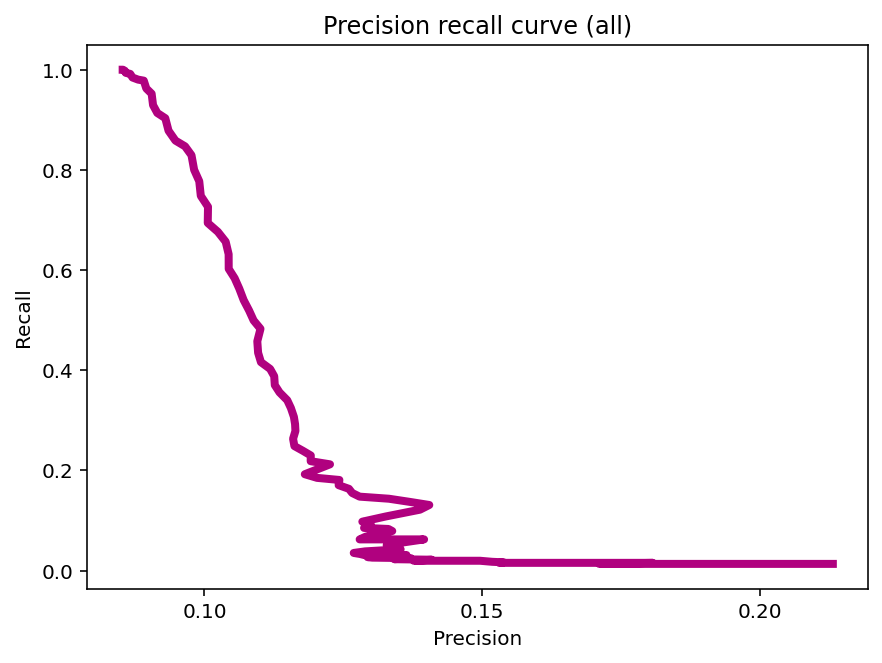

In [29]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis='x', nbins=5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color='#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})


plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [30]:
new_list = []
for i in zip(threshold_values, recall_all):
    thre, recall = i

    if recall >= 0.80:
        new_list.append(thre)

print(max(new_list))

0.10606060606060606


Legitimate No Readmission Detected  (True Negatives) :  3242

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  7067

Legitimate Readmission Missed       (False Negatives):  192

Legitimate Readmission Detected     (True Positives) :  769


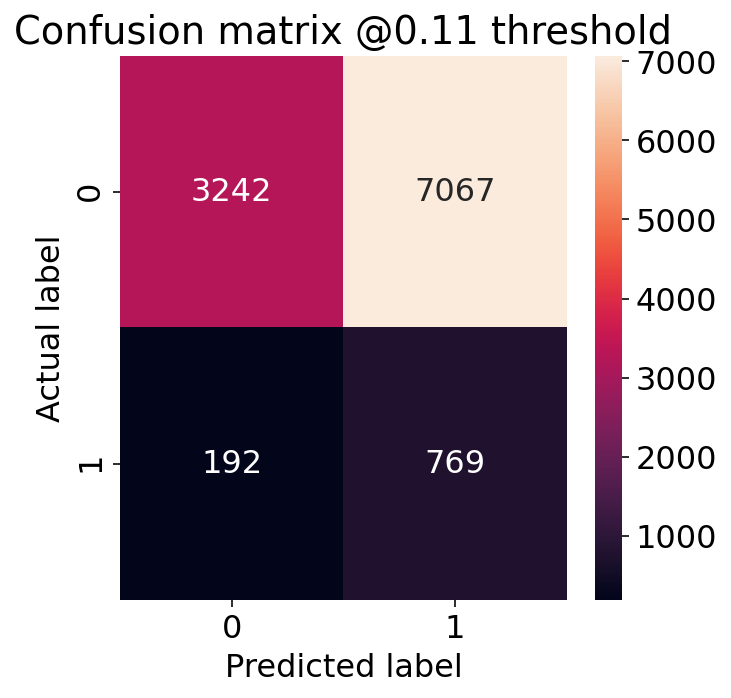

In [31]:
plot_cm(y_val, loaded_model.predict(dvalidation), p=0.1060606060606060)

In [32]:
print('Area under the curve : %f' %
      (metrics.roc_auc_score(y_val, y_val_preds)))

Area under the curve : 0.504436


# Test Data

In [33]:
y_test_pred_proba = loaded_model.predict(dtest)
# Threshold
thresh = 0.1060606060606060
y_test_preds = [1 if pred >thresh else 0 for pred in y_test_pred_proba]

Legitimate No Readmission Detected  (True Negatives) :  4013

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  8784

Legitimate Readmission Missed       (False Negatives):  265

Legitimate Readmission Detected     (True Positives) :  1025


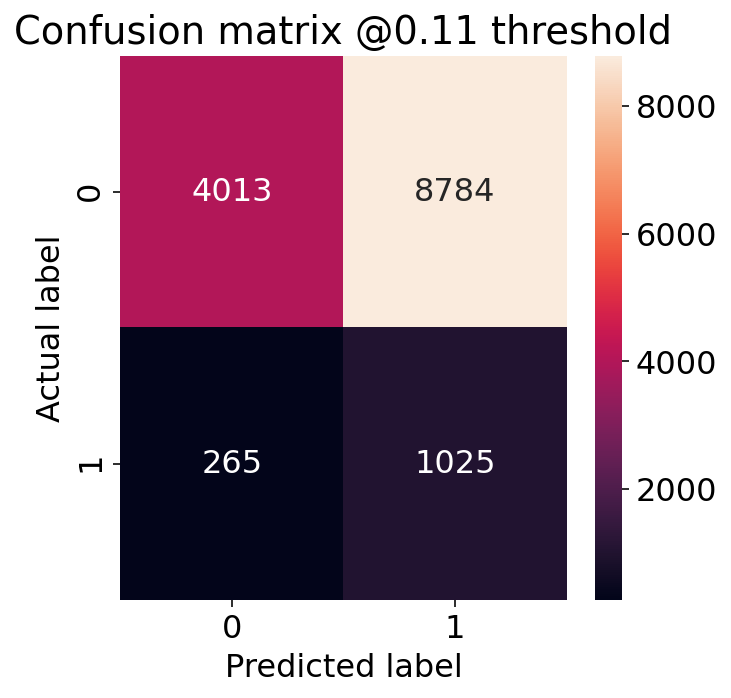

In [34]:
plot_cm(y_test, loaded_model.predict(dtest), p=0.1060606060606060)

In [35]:
print('Area under the curve : %f' %
      (metrics.roc_auc_score(y_test, y_test_preds)))

Area under the curve : 0.554081


# Model Evaluation with fewer features

## Tuning Threshold on Validation Data

In [36]:
# Load Model
loaded_model_75 = xgb.Booster()
loaded_model_75.load_model("../models/best_model_75.model")

In [43]:
##### Predict Probability
y_val_pred_proba_75 = loaded_model_75.predict(dvalidation)

# Predict true value at a 0.5 threshold
y_val_preds_75 = [1 if pred >0.5 else 0 for pred in y_val_pred_proba_75]

# Print 
print(classification_report(y_val, y_val_preds_75))

              precision    recall  f1-score   support

           0       0.92      0.52      0.67     10309
           1       0.09      0.54      0.16       961

    accuracy                           0.52     11270
   macro avg       0.51      0.53      0.41     11270
weighted avg       0.85      0.52      0.62     11270



Legitimate No Readmission Detected  (True Negatives) :  5376

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  4933

Legitimate Readmission Missed       (False Negatives):  446

Legitimate Readmission Detected     (True Positives) :  515


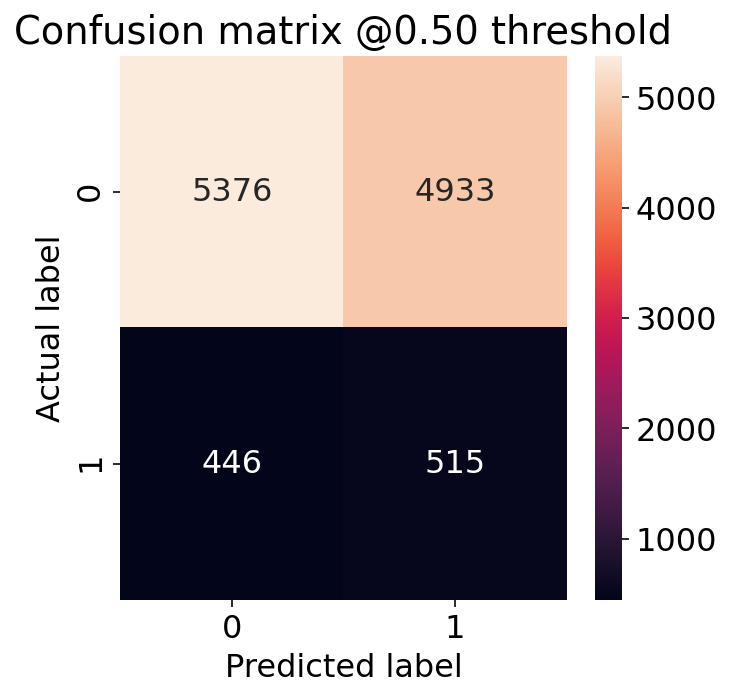

In [44]:
plot_cm(y_val, loaded_model_75.predict(dvalidation), p=0.5)

In [45]:
precision = precision_score(y_true=y_val, 
                            y_pred=y_val_preds_75)
print ("Precision on validation data: {:.3f}".format(precision))

recall = recall_score(y_true=y_val,
                     y_pred=y_val_preds_75)
print ("Recall on validation data: {:.3f}".format(recall))

Precision on validation data: 0.095
Recall on validation data: 0.536


In [46]:
# Compute Precision for every threshold value
precision_all_75 = [precision_score(y_true=y_val, y_pred=apply_threshold(loaded_model_75.predict(dvalidation), threshold)) for threshold in threshold_values]
# Compute Recall for every threshold value
recall_all_75 = [recall_score(y_true=y_val, y_pred=apply_threshold(loaded_model_75.predict(dvalidation), threshold)) for threshold in threshold_values]

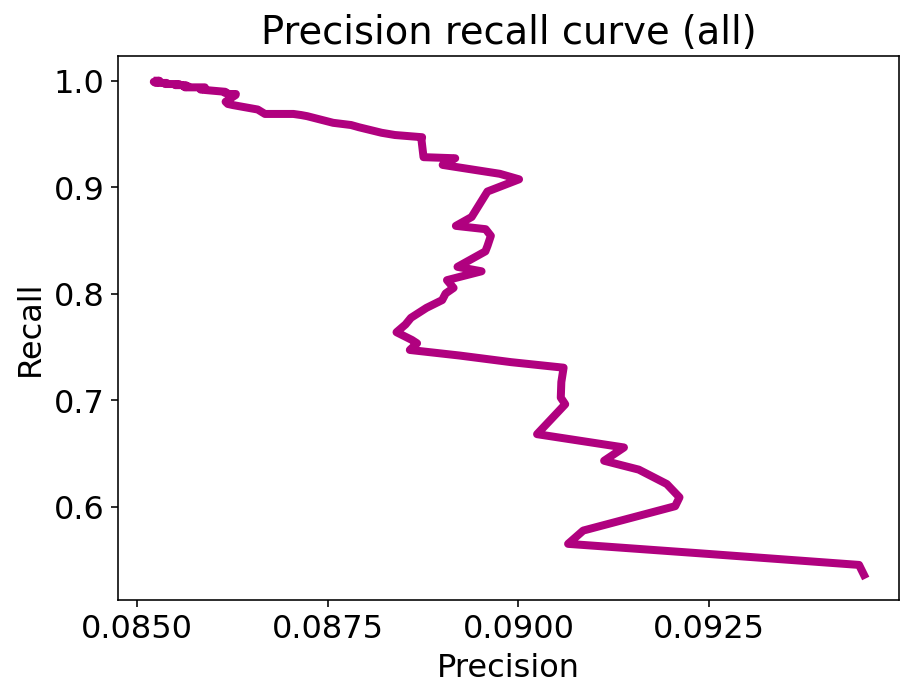

In [47]:
plot_pr_curve(precision_all_75, recall_all_75, 'Precision recall curve (all)')

In [63]:
new_list = []
for i in zip(threshold_values, recall_all_75):
    thre, recall = i

    if recall >= 0.90:
        new_list.append(thre)

print(max(new_list))

0.3080808080808081


Legitimate No Readmission Detected  (True Negatives) :  1493

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  8816

Legitimate Readmission Missed       (False Negatives):  89

Legitimate Readmission Detected     (True Positives) :  872


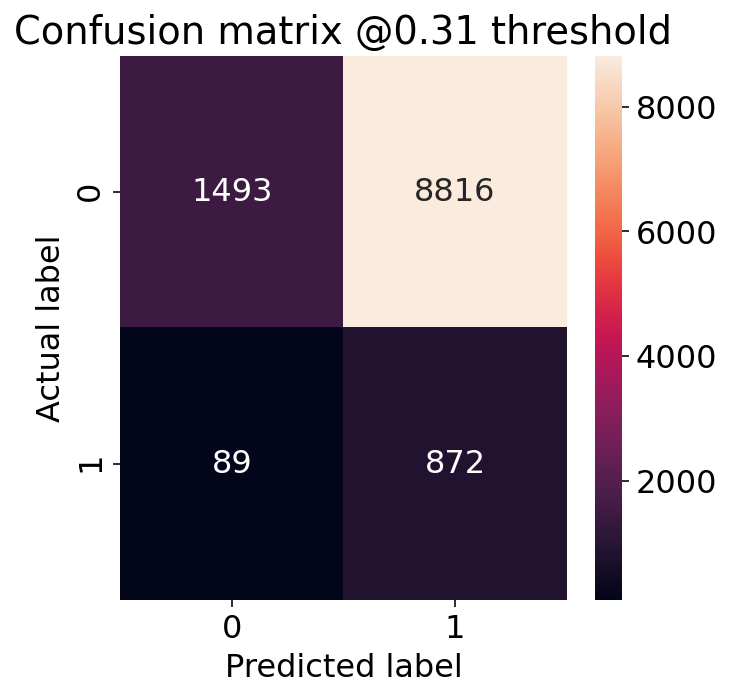

In [64]:
plot_cm(y_val, loaded_model_75.predict(dvalidation), p=0.3080808080808081)

In [65]:
print('Area under the curve : %f' %
      (metrics.roc_auc_score(y_val, y_val_preds_75)))

Area under the curve : 0.528693


## Performance on Test Data

Legitimate No Readmission Detected  (True Negatives) :  1847

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  10950

Legitimate Readmission Missed       (False Negatives):  148

Legitimate Readmission Detected     (True Positives) :  1142

Area under the curve : 0.514801


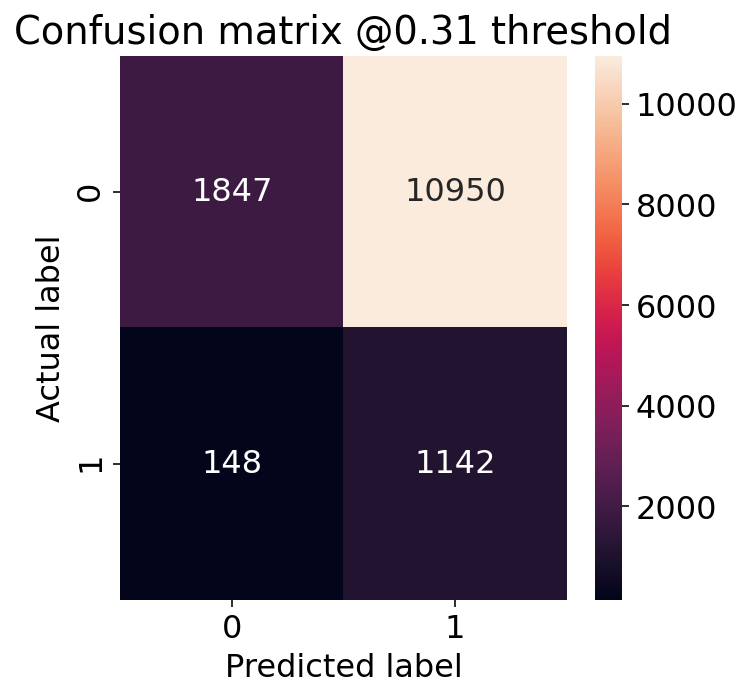

In [70]:
y_test_pred_proba = loaded_model_75.predict(dtest)
# Threshold
thresh = 0.3080808080808081
y_test_preds = [1 if pred >thresh else 0 for pred in y_test_pred_proba]

plot_cm(y_test, loaded_model_75.predict(dtest), p=0.3080808080808081)

print('\nArea under the curve : %f' %
      (metrics.roc_auc_score(y_test, y_test_preds)))

# Feature Selection

In [72]:
# Load the full model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("../models/best_model_001.model")

In [75]:
# Define Thresholds
thresholds = loaded_model.feature_importances_
thresholds

TypeError: 'NoneType' object is not iterable

In [ ]:
best_model.get_score(importance_type='weight')